In [1]:

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
MODEL_PATH = "cb2cf_multi_modal_encoder_model.pt"

c:\Users\tsale\OneDrive\Desktop\CS Masters Degree\Recommendation Systems\Project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the model from  cb2cf_multi_modal_encoder.pt state_dict

model = torch.load(MODEL_PATH)
model.eval()

CB2CFMultiModalEncoder(
  (text_encoding_model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 400, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
    (2): Normalize()
  )
  (genres_embedding): Sequential(
    (0): Linear(in_features=20, out_features=80, bias=True)
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (actors_embedding): Sequential(
    (0): Linear(in_features=3324, out_features=80, bias=True)
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (directors_embedding): Sequential(
    (0): Linear(in_features=1578, out_features=40, bias=True)
    (1): BatchNorm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Using device: cuda:0


In [4]:
test_data = torch.load("cb2cf_test_dataset.pt")


In [5]:
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)


In [6]:
# Run eval on the test set with MSE loss

with torch.no_grad():
    total_loss = 0
    for i, data in enumerate(tqdm(test_dataloader)):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        loss = torch.nn.functional.mse_loss(output, data["embeddings"].to(device))
        total_loss += loss.item()
    print("MSE loss on test set:", total_loss / len(test_dataloader))

100%|██████████| 991/991 [00:11<00:00, 88.87it/s] 

MSE loss on test set: 0.4256489030813834


In [7]:
# Save embeddings and title for items in test set

with torch.no_grad():
    test_embeddings = []
    titles = []
    test_movie_ids = []
    for i, data in enumerate(tqdm(test_dataloader)):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        test_embeddings.append(output.cpu().squeeze().numpy())
        test_movie_ids.append(data["movie_ids"])
        
        titles.append(data["title"])



100%|██████████| 991/991 [00:09<00:00, 104.17it/s]


In [8]:
# Pick a random movie from the test set and find the 10 most similar movies
# by cosine similarity from embeddings

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# squeeze the embeddings to remove the batch dimension

random_movie_index = np.random.randint(0, len(test_data))
random_movie_embedding = test_embeddings[random_movie_index]
random_movie_title = titles[random_movie_index]

cosine_similarities = cosine_similarity([random_movie_embedding], test_embeddings)
most_similar_indices = cosine_similarities.argsort()[0][-10:][::-1]

print("Most similar movies to", random_movie_title)
for index in most_similar_indices:
    print(titles[index])

Most similar movies to ['Андрей Рублёв']
['Андрей Рублёв']
['Ива́ново де́тство']
['Nostalghia']
['Accattone']
['La notte']
['Der siebente Kontinent']
['Il conformista']
['Une Femme est une femme']
['I Walked with a Zombie']
['Jungfrukällan']


In [9]:
# Load train dataset and produce train embeddings

train_data = torch.load("cb2cf_train_dataset.pt")
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=0)

with torch.no_grad():
    train_embeddings = []
    train_titles = []
    train_movie_ids = []
    for i, data in enumerate(tqdm(train_dataloader)):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        train_embeddings.append(output.cpu().squeeze().numpy())
        train_titles.append(data["title"])
        train_movie_ids.append(data["movie_ids"])




100%|██████████| 8911/8911 [01:24<00:00, 105.52it/s]


In [10]:
import pandas as pd

In [53]:
oracle_item_embeddings = pd.read_pickle(r"BPR1_item_embeddings.pkl")

# convert train_movie ids and test movie ids to list of integers

train_movie_ids = [int(movie_id) for movie_id in train_movie_ids]
test_movie_ids = [int(movie_id) for movie_id in test_movie_ids]

oracle_train_item_embeddings = oracle_item_embeddings[train_movie_ids]
oracle_test_item_embeddings = oracle_item_embeddings[test_movie_ids]
# all ids 
all_movie_ids = train_movie_ids + test_movie_ids
# all titles
all_titles = train_titles + titles
# all oracle embeddings
all_oracle_embeddings = np.concatenate((oracle_train_item_embeddings, oracle_test_item_embeddings), axis=0)

In [54]:
# for each test movie compute cosine similarity with all movies in all_oracle_embeddings, remove the test movie itself

oracle_test_cosine_similarities = cosine_similarity(oracle_test_item_embeddings , all_oracle_embeddings)
cb2cf_test_cosine_similarities = cosine_similarity(test_embeddings, train_embeddings + test_embeddings)

# arg_sort all the cosine similarities to get all the indices by similarity

oracle_test_indices = oracle_test_cosine_similarities.argsort()[:, :][:, ::-1]
cb2cf_test_indices = cb2cf_test_cosine_similarities.argsort()[:, :][:, ::-1]

# remove the first index which is the test movie itself

oracle_test_indices = oracle_test_indices[:, 1:]
cb2cf_test_indices = cb2cf_test_indices[:, 1:]






In [125]:
# Compute the NDCG score for cb2cf_test_cosine_similarities where oracle_test_cosine_similarities is the ground truth


random_movie_index = 1
random_movie_embedding = test_embeddings[random_movie_index]
random_movie_title = titles[random_movie_index]

cosine_similarities = cosine_similarity([random_movie_embedding], train_embeddings + test_embeddings)
most_similar_indices = cosine_similarities.argsort()[0][-10:][::-1]

# compute the same for oracle_test_cosine_similarities
random_movie_embedding_oracle = oracle_test_item_embeddings[random_movie_index]
oracle_cosine_similarities = cosine_similarity([random_movie_embedding_oracle], all_oracle_embeddings)
oracle_most_similar_indices = oracle_cosine_similarities.argsort()[0][-10:][::-1]
print("Most similar movies to", random_movie_title)
for index in most_similar_indices:
    print(all_titles[index])

print("Oracle most similar movies to", random_movie_title)
for index in oracle_most_similar_indices:
    print(all_titles[index])


Most similar movies to ['Sabrina']
['Sabrina']
['Working Girl']
['Wuthering Heights']
['Primary Colors']
['On Golden Pond']
['Dead Man Walking']
['Sliding Doors']
['Private Benjamin']
['This Is My Father']
['Hilary and Jackie']
Oracle most similar movies to ['Sabrina']
['Sabrina']
['French Kiss']
['A Walk in the Clouds']
['It Could Happen to You']
['I.Q.']
['While You Were Sleeping']
['The Englishman Who Went Up a Hill But Came Down a Mountain']
['Only You']
['Forget Paris']
['One Fine Day']


In [126]:
# remove values of 1 from oracle_test_cosine_similarities and cb2cf_test_cosine_similarities

for i in range(len(oracle_test_cosine_similarities)):
    oracle_test_cosine_similarities[i][len(train_embeddings) + i] = -1
    cb2cf_test_cosine_similarities[i][len(train_embeddings) + i] = -1
# oracle_test_cosine_similarities[oracle_test_cosine_similarities == 1.0] = -1
# cb2cf_test_cosine_similarities[cb2cf_test_cosine_similarities == 1.0] = -1
# convert the cosine similarity to relevance scores to be positive by adding 1

oracle_test_relevance_scores_normalized = (oracle_test_cosine_similarities + 1) / 2
cb2cf_test_relevance_scores_normalized = (cb2cf_test_cosine_similarities + 1) / 2

NDCG scores for k = 10, 50, 100, 500
[0.8876633124104583, 0.8888784770655952, 0.8898789762924665, 0.8940228071107246]


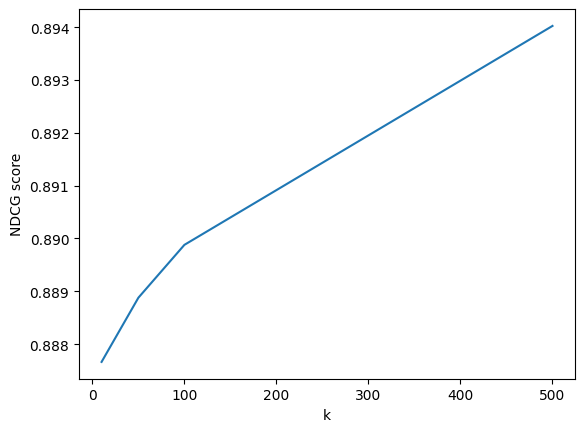

In [128]:
# Compute NDCG score for cb2cf_test_cosine_similarities where oracle_test_cosine_similarities is the ground truth

from sklearn.metrics import ndcg_score


# compute the NDCG score for each test movie
k_values = [10,50, 100,500]
ndcg_scores = []
for k in k_values:
    cb2cf_ndcg_avg = ndcg_score(oracle_test_relevance_scores_normalized,cb2cf_test_relevance_scores_normalized, k=k)
    ndcg_scores.append(cb2cf_ndcg_avg)

print("NDCG scores for k = 10, 50, 100, 500")
print(ndcg_scores)

# plot the NDCG scores for different k values

import matplotlib.pyplot as plt

plt.plot(k_values, ndcg_scores)
plt.xlabel("k")
plt.ylabel("NDCG score")
plt.show()

